## Install dependencies

In [1]:
%pip install -q pystac_client


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


---

In [60]:
import math

from rastervision.core.box import Box
from rastervision.core.data import (RasterioCRSTransformer, StatsTransformer,
                                    XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset)

import numpy as np
import torch
from shapely.geometry import mapping, shape
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get a time-series of Sentinel-2 images from a STAC API

Get Sentinel-2 imagery from 2023-06-01 to 2023-06-20 over Paris, France.

In [3]:
import pystac_client
import stackstac

In [29]:
# Tarim basin
# 40.721508, 87.611254
# 40.574240, 87.821939

bbox = Box(ymin=40.721508, xmin=87.611254, ymax=40.574240, xmax=87.821939)
# smaller
bbox = Box(ymin=40.647, xmin=87.717, ymax=40.574, xmax=87.821)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [36]:
# Pak-Afghan border, Chagai
# 29.332858, 63.462233
# 29.122067, 63.796269

bbox = Box(ymin=29.332, xmin=63.462, ymax=29.122, xmax=63.796)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [73]:
def item_bbox_iou(item, bbox):
    item_polygon = shape(item.geometry)
    bbox_polygon = bbox.to_shapely()
    iou = item_polygon.intersection(bbox_polygon).area / bbox_polygon.area
    return iou

In [77]:
URL = 'https://earth-search.aws.element84.com/v1'
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=['sentinel-2-l2a'],
    datetime='2023-06-20/2023-07-20',
    # query={"eo:cloud_cover": {"lt": 5}},
).get_all_items()
items = [item for item in items if item_bbox_iou(item, bbox) == 1.]

print(f'{len(items)=}')

stack = stackstac.stack(items)
stack

len(items)=6


<xarray.DataArray 'stackstac-009f865206c430a2e5f7dae8d9e61360' (time: 6,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(6, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2023-06-23...
    id                                       (time) <U24 'S2A_41RNN_20230623_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 5e+05 ... 6.098e+05
  * y                                        (y) float64 3.3e+06 ... 3.19e+06
    processing:software                      (time) object {'sentinel2-to-sta...
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32641
Attributes:
    spec:        RasterSpec(epsg=32641, bounds=(499980.0, 3190200.0, 609780.0...
    crs:         epsg:32641
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 3300000.00|\n| 0.0...
    resolution:  10.0

In [78]:
data_array = stack.sel(
    band=[
        'red', # B04
        'green', # B03
        'blue', # B02
    ])

### Convert to a Raster Vision `RasterSource`

In [79]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

### Create the `RasterSource`

In [84]:
bbox_pixel_coords = crs_transformer.map_to_pixel(bbox).normalize()
# bbox_pixel_coords = bbox_pixel_coords.center_crop(500, 1000)
# print(bbox_pixel_coords.size)
# bbox_pixel_coords = Box(
#     ymin=10010, 
#     xmin=bbox_pixel_coords.xmin+900, 
#     ymax=bbox_pixel_coords.ymax, 
#     xmax=bbox_pixel_coords.xmax)

raster_source_unnormalized = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    bbox=bbox_pixel_coords,
    temporal=True)
raster_source_unnormalized.shape

(6, 2309, 3259, 3)

In [ ]:
raster_source_stats = XarraySource(
    data_array,
    # data_array.isel(time=[-1, -2]),
    crs_transformer=crs_transformer,
    bbox=bbox_pixel_coords,
    temporal=True)

stats_tf = StatsTransformer.from_raster_sources([raster_source_stats])

In [86]:
raster_source_viz = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    bbox=bbox_pixel_coords,
    # channel_order=[4, 3, 2],
    temporal=True)
raster_source_viz.shape

(6, 2309, 3259, 3)

Visualize the images in the time-series:

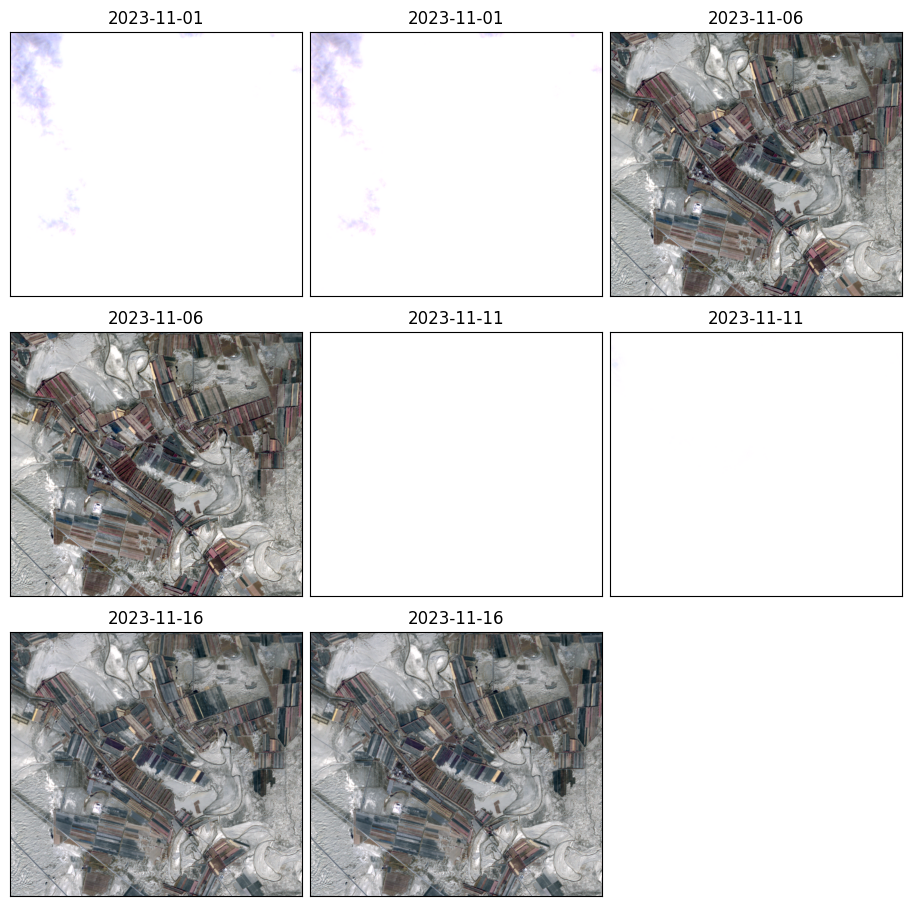

In [27]:
T = raster_source_viz.shape[0]
t_strs = [str(s.date()) for s in raster_source_viz.data_array.time.to_series()]

ncols = 3
nrows = int(math.ceil(T / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3), constrained_layout=True)
for t, t_str, ax in zip(range(T), t_strs, axs.flat):
    chip = raster_source_viz[t, :, :]
    ax.imshow(chip)
    ax.set_title(t_str, fontsize=12)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
for i in range(t + 1, len(axs.flat)):
    axs.flat[i].axis('off')
plt.show()

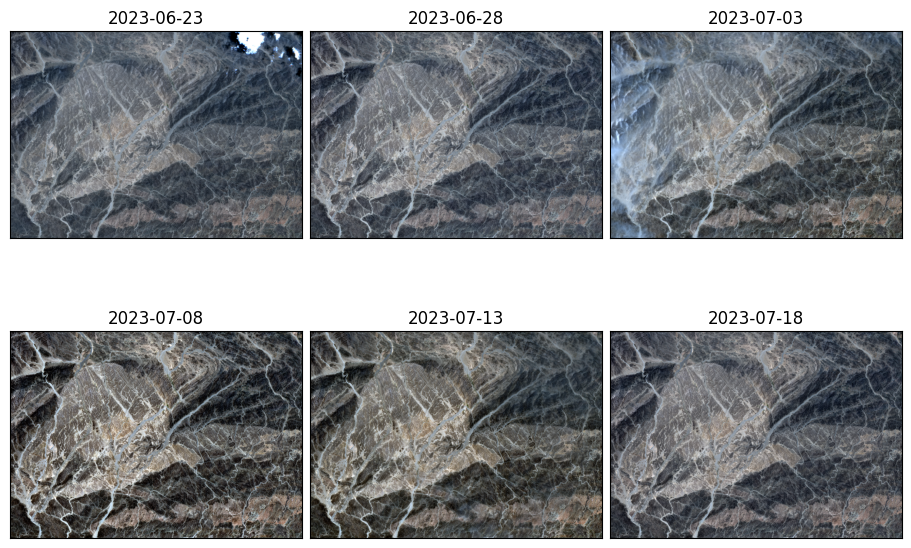

In [87]:
T = raster_source_viz.shape[0]
t_strs = [str(s.date()) for s in raster_source_viz.data_array.time.to_series()]

ncols = 3
nrows = int(math.ceil(T / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3), constrained_layout=True)
for t, t_str, ax in zip(range(T), t_strs, axs.flat):
    chip = raster_source_viz[t, :, :]
    ax.imshow(chip)
    ax.set_title(t_str, fontsize=12)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
for i in range(t + 1, len(axs.flat)):
    axs.flat[i].axis('off')
plt.show()